# <center>Rozwiązywanie układów równań</center>
# <center>Metody iteracyjne</center>

Instrukcja:
Na zajęciach należy wykonać poniższe zadania, a następnie sporządzić sprawozdanie zawierające odpowiedzi (w postaci kodu) z komentarzami w środowisku Jupyter Notebook i umieścić je na platformie e-learningowej.   

In [4]:
import main
import scipy as sp
import numpy as np
import scipy.sparse.linalg as sp_linalg
import numpy.linalg as np_linalg
import matplotlib
import matplotlib.pyplot as plt
from typing import Union, List, Tuple, Optional

**Cel zajęć:**  
Celem zajęć jest zapoznanie się z iteracyjnymi metodami rozwiązywania układów równań liniowych w postaci macierzowej. Metody iteracyjne, w przeciwieństwie do analitycznych, nie zwracają dokładnego rozwiązania, a jedynie jego przybliżenie. Przy spełnionych kryteriach, przybliżenia obliczane w kolejnych iteracjach są zbieżne do dokładnego rozwiązania. Metody iteracyjne znajdują swoje zastosowanie szczególnie przy dużych układach równań postaci: 
   
$
\mathbf{Ax}=\mathbf{b}
$ 
  
gdzie $\mathbf{A}$ to macierz współczynników z lewej strony równania, wektor $\mathbf{x}$ jest wektorem zmiennych a wektor $\mathbf{b}$ wyników prawej strony równania.  

Do oceny jakości rozwiązania będziemy wykorzystywać residuum (ang. *residual*)
$
\mathbf{r}=\mathbf{b}-\mathbf{Ax}
$ 
  

***Zadanie 1***   
Zdefiniuję funkcję *diag_dominant_matrix_A_b*, przyjmującą paramter całkowity $m>0$ która zwróci:
- macierz diagonalnie zdominowana $\mathbf{A}$ o wymiarach $m \times m$ (wyrazy na przekątnej sa wieksze co do modułu od sumy pozostałych w danej kolumnie i wierszu)
- wektor $\mathbf{b}$ o wymiarach $m \times 1$ 
 
o losowych wartościach całkowitych

Dodatkowo zdefiniuj funkcje *is_diag_dominant* sprawdzającą czy zadana macierz jest diagonalnie zdominowana

In [5]:
#DEFINICJA FUNKCJI TWORZĄCEJ MACIERZ DIAGONALNIE ZDOMINOWANĄ
def diag_dominant_matrix_A_b(m: int) -> Tuple[np.ndarray, np.ndarray]:
    if type(m) is not int or m<=0: #SPRAWDZENIE WARUNKÓW ZADANIA
        return None
    A = np.random.randint(0,100,size=(m,m)) # MACIERZ I WEKTOR WARTOŚCI RANDOMOWYCH
    b = np.random.randint(0,9,m)
    v_diag = np.array(np.diag(A)) # WEKTOR WARTOŚCI Z DIAGONALI
    A_temp = A - np.eye(m)*v_diag #USUWANIE WARTOSCI Z DIAGONALI
    for i in range(m): #SPRWADZANIE CZY WART NA DIAG WIEKSZE
        #WIERSZ
        if np.abs(v_diag[i]) < np.sum(A_temp[i,:]):
            v_diag[i] = v_diag[i] + np.sum(A_temp[i,:]) - np.abs(v_diag[i]) + np.random.randint(0,100)
        #KOLUMNA
        if np.abs(v_diag[i]) < np.sum(A_temp[:,i]):
            v_diag[i] = v_diag[i] + np.sum(A_temp[:,i]) - np.abs(v_diag[i]) + np.random.randint(0,100)
    for i in range(m):
        A[i,i] = v_diag[i]

    return A, b

#FUNKCJA SPRAWDZAJĄCA CZY MACIERZ JEST DIAGONALNIE ZDOMINOWANA
def is_diag_dominant(A: np.ndarray) -> bool:
    if type(A) is not np.ndarray or len(np.shape(A)) != 2:
        return None
    if np.shape(A)[0] != np.shape(A)[1]:
        return None
    m = np.shape(A)[0]
    v_diag = np.array(np.diag(A))
    A_temp = A - np.eye(m)*v_diag
    for i in range(m):
        #WIERSZ
        if np.abs(v_diag[i]) < np.sum(A_temp[i,:]):
            return False
        #KOLUMNA
        if np.abs(v_diag[i]) < np.sum(A_temp[:,i]):
            return False
    return True

***Zadanie 2***   
Zdefiniuję funkcję *symmetric_matrix_A_b*, przyjmującą paramter całkowity $m>0$ która zwróci:
- symetryczną macierz $\mathbf{A}$ o wymiarach $m \times m$ (wyrazy symetryczne względnej przekątnej są sobie równe)
- wektor $\mathbf{b}$ o wymiarach $m \times 1$ 
 
o losowych wartościach całkowitych

Dodatkowo zdefiniuj funkcje is_symmetric sprawdzającą czy zadana macierz jest symetryczna

In [6]:
#FUNKCJA TWORZĄCA MACIERZ SYMETRYCZNĄ ORAZ WEKTOR B
def symmetric_matrix_A_b(m: int) -> Tuple[np.ndarray, np.ndarray]:
    if type(m) is not int or m<=0:
        return None 

    A = np.random.randint(0,100,size=(m,m))
    b = np.random.randint(0,9,m)
    return (A+np.transpose(A)), b

#FUNKCJA SPRAWDZAJĄCA, CZY MACIERZ JEST SYMETRYCZNA
def is_symmetric(A: np.ndarray) -> bool:
    if type(A) is not np.ndarray or len(np.shape(A)) != 2:
        return None
    if np.shape(A)[0] != np.shape(A)[1]:
        return None
    for i in range(np.shape(A)[0]):
        for j in range(np.shape(A)[1]):
            if A[i][j]!=A[j][i]:
                return False
    return True

***Zadanie 3***   
Zdefiniuję następujące układy równań:

a) $\mathbf{A_1}$, $\mathbf{b_1}$: gdzie $\mathbf{A_1}$ jest macierzą o wymiarach $m \times m$, a $\mathbf{b_1}$ wektorem $m \times 1$, $m = 10$

b) $\mathbf{A_2}$, $\mathbf{b_2}$: gdzie $\mathbf{A_2}$ jest macierzą **diagonalnie zdominowaną** o wymiarach$m \times m$, a $\mathbf{b_2}$ wektorem $m \times 1$, $m = 10$
 
c) $\mathbf{A_3}$, $\mathbf{b_3}$: gdzie $\mathbf{A_3}$ jest macierzą **symetryczną** o wymiarach $m \times m$, a $\mathbf{b_3}$ wektorem $m \times 1$, $m = 10$   
 
**Wskazówka**: Do generacji macierzy użyj metody *random_matrix_Ab* z lab6 oraz metod *diag_dominant_matrix_A_b* i *symmetric_matrix_A_b*

In [7]:
# Wklejam definicję funkcji z 6 laboratoriów, która będzie potrzebna do wykonania powyższego zadania.
def random_matrix_Ab(m:int):
    if type(m) is not int or m<=0:
        return None
    A = np.random.randint(m,size = (m,m))
    b = np.random.randint(m,size = m)
    return A,b


# a)
m = 10
A1, b1 = random_matrix_Ab(m)

# b)
A2, b2 = diag_dominant_matrix_A_b(m)

# c)
A3, b3 = symmetric_matrix_A_b(m)

***Zadanie 4***   
Zaimplementuj iteracyjną metodę *solve_jacobi*, rozwiązującą układ równań metodą Jacobiego zgodnie z dokumentacją w pliku *main.py*.
Szczegóły metody zostały przedstawione na wykładzie.

In [8]:
def solve_jacobi(A: np.ndarray, b: np.ndarray, x_init: np.ndarray,
                 epsilon: Optional[float] = 1e-8, maxiter: Optional[int] = 100) -> Tuple[np.ndarray, int]:
    if type(A) is not np.ndarray or type(b) is not np.ndarray or type(x_init) is not np.ndarray:
        return None
    if type(epsilon) not in [None, float] or type(maxiter) not in [None, int]:
        return None
    if len(np.shape(A)) != 2:
        return None
    if np.shape(A)[0] != np.shape(A)[1] or np.shape(A)[0] != len(b):
        return None
    if len(x_init) != len(b) or epsilon < 0 or maxiter<0:
        return None
    D = np.diag(np.diag(A)) #dwa razy żeby była macierz a nie wektor
    LU = A - D
    x = x_init
    D_inv = np.diag(1/np.diag(D))
    resid = []
    n = 0
    for i in range(maxiter):
        x_new = np.dot(D_inv,b - np.dot(LU,x))
        r_norm = np.linalg.norm(x_new - x)
        resid.append(r_norm)
        n = i+1
        if r_norm<epsilon:
            return x_new, n
        x = x_new
    return x, n

***Zadanie 5***   
Rozwiąż układ równań z Zadania 3 podpunkt a) przy pomocy:

- funkcji *[solve](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.solve.html?highlight=solve#numpy.linalg.solve)* z biblioteki numpy

- zaimplementowanej iteracyjnej metody *solve_jacobi*

- iteracyjnej metody *[gradientów sprzężonych](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.cg.html)*
 z biblioteki scipy

- iteracyjnej metody *[GMRES](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.gmres.html)*
 z biblioteki scipy

Przed każdą metodą sprawdź czy warunki dotyczące macierzy dla danej metody są spełnione. Zbadaj dokładność i czas obliczeń metod w zależności od liczby iteracji. Wyniki przedstaw na wykresach.

In [9]:
### ROZWIĄZANIA UKŁADU RÓWNAŃ Z ZADANIA 3 Z PODPUNKTU a) PRZY POMOCY:  

print("MACIERZ A1 Z ZADANIA 3 Z PODPUNKTU a)\n")
# SOLVE
solution_S_1 = np_linalg.solve(A1,b1)
print("Wynik dla macierzy A1 i funkcji SOLVE: ",solution_S_1,"\n\n")

# SOLVE JACOBI
print("METODA SOLVE JACOBI\n")
condition_SJ_1 = is_diag_dominant(A1)
print("Czy warunek dla funkcji solve_jacobi i macierzy A1 jest spełniony? ",condition_SJ_1,"\n")
x_init = np.zeros(m)
solution_SJ_1, n_1 = solve_jacobi(A1,b1,x_init)
print("Wynik dla macierzy A1 i funkcji solve_jacobi: ",solution_SJ_1,"\n")
print("Liczba iteracji: ",n_1,"\n\n")

# GRADIENTY SPRZĘŻONE
print("METODA GRADIENTÓW SPRZĘŻONYCH\n")
condition_GS_1 = is_symmetric(A1)
print("Czy warunek dla gradientów sprzężonych i macierzy A1 jest spełniony? ",condition_GS_1,"\n")
solution_GS_1, _ = sp_linalg.cg(A1,b1)
print("Wynik dla macierzy A1 i metody Gradientów sprzeżonych: ",solution_GS_1,"\n\n")

# GMRES
solution_GMRES_1, _ = sp_linalg.gmres(A1,b1)
print("Wynik dla macierzy A1 i funkcji GMRES: ",solution_GMRES_1,"\n\n")

MACIERZ A1 Z ZADANIA 3 Z PODPUNKTU a)

Wynik dla macierzy A1 i funkcji SOLVE:  [-0.80020135 -2.86582098 -0.1733183   1.71709592  3.19165443 -0.88124877
 -1.15286248  1.36267825 -0.19989202  0.58599791] 


METODA SOLVE JACOBI

Czy warunek dla funkcji solve_jacobi i macierzy A1 jest spełniony?  False 

Wynik dla macierzy A1 i funkcji solve_jacobi:  [nan nan nan nan nan nan nan nan nan nan] 

Liczba iteracji:  100 


METODA GRADIENTÓW SPRZĘŻONYCH

Czy warunek dla gradientów sprzężonych i macierzy A1 jest spełniony?  False 

Wynik dla macierzy A1 i metody Gradientów sprzeżonych:  [  872046.57448941 -6217679.46639238   247350.43369586  2544959.69930875
   314139.41277849 -3383515.57266383  1230020.52241022 -2474156.384654
  2569668.63569333  2015361.43618709] 


Wynik dla macierzy A1 i funkcji GMRES:  [-0.80020135 -2.86582098 -0.1733183   1.71709592  3.19165443 -0.88124877
 -1.15286248  1.36267825 -0.19989202  0.58599791] 




WNIOSKI: 
- DLA METODY GRADIENTÓW SPRZEŻONYCH NIE JEST SPEŁIONY WARUNEK DOTYCZĄCY SYMETRYCZNOŚCI MACIERZY A1, WIĘC WYNIKI SĄ BŁĘDNE. 
- DLA METODY JACOBIEGO NIE JEST SPEŁNIONY WARUNEK DOTYCZĄCY DIAGNOALNEJ DOMINACJI, WIĘC WYNIKI TAKŻE OTRZYMUJEMY ODBIEGAJĄCE OD PRAWDZIWYCH.
- DLA METODY SOLVE ORAZ GMRES OTRZYMUJEMY PODOBNE WYNIKI, MOŻEMY WNIOSKOWAĆ WIĘC, ŻE SĄ ONE PRAWDZIWE A FUNKCJE DZIAŁAJĄ PRAWIDŁOWO.

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
Timing: 
325 µs ± 28.2 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 146.33 MiB, increment: 0.00 MiB


Timing: 
295 µs ± 16.4 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 146.33 MiB, increment: 0.00 MiB


Timing: 
298 µs ± 13.3 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 146.33 MiB, increment: 0.00 MiB


Timing: 
294 µs ± 10.7 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 146.33 MiB, increment: 0.00 MiB


Timing: 
294 µs ± 8.76 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 146.33 MiB, increment: 0.00 MiB


Timing: 
294 µs ± 9.87 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 146.33 MiB, increment: 0.00 MiB




[Text(0, 0.5, 'norma residuum'),
 Text(0.5, 0, 'maxiter'),
 Text(0.5, 1.0, 'Wykres normy residuum w zależności od wart. parametru maxiter')]

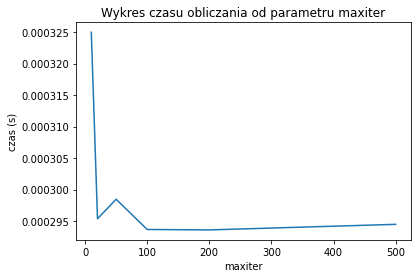

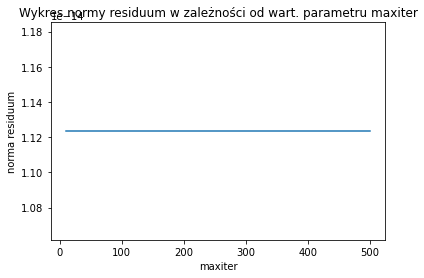

In [27]:
%load_ext memory_profiler

#GMRES
max_iter = [10, 20, 50, 100, 200, 500]
time_list = list()
error_list = list()
for iterations_number in max_iter:
    print('Timing: ')
    saved_timing = %timeit -r 5 -n 10 -o sp_linalg.gmres(A1,b1, maxiter = iterations_number)
    st = saved_timing.average   # średni czas próby
    time_list.append(st)
    error_list.append(np.linalg.norm(A1@sp_linalg.gmres(A1,b1)[0] - b1))
    saved_timing.stdev     # odchylenie standardowe
    print('Memory usage: ')
    %memit sp_linalg.gmres(A1,b1, maxiter = iterations_number)
    print('\n')

fig, ax1 = plt.subplots()
ax1.plot(max_iter,time_list)
ax1.set(title="Wykres czasu obliczania od parametru maxiter",xlabel="maxiter",ylabel="czas (s)")

fig, ax2 = plt.subplots()
ax2.plot(max_iter,error_list)
ax2.set(title="Wykres normy residuum w zależności od wart. parametru maxiter",xlabel="maxiter",ylabel="norma residuum")

WNIOSKI DLA WYKRESU:
- NORMA RESIDUUM PRAWIE NA POZIOMIE ZERA MASZYNOWEGO,
- CZAS OBLICZANIA JUZ PRZY 10 INTERACJACH JEST PRAWIE TAK MAŁY JAK PRZY WIĘKSZEJ LICZBIE ITERACJI.
- WYSTARCZY MNIEJ NIŻ 10 ITERACJI ABY OTRZYMAĆ BARDZO DOBRY WYNIK (PRAKTYCZNIE NAJLEPSZY MOŻLIWY).

***Zadanie 6***     
Rozwiąż układ równań z Zadania 3 podpunkt b) przy pomocy:

- funkcji *[solve](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.solve.html?highlight=solve#numpy.linalg.solve)* z biblioteki numpy

- zaimplementowanej iteracyjnej metody *solve_jacobi*

- iteracyjnej metody *[gradientów sprzężonych](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.cg.html)*
 z biblioteki scipy

- iteracyjnej metody *[GMRES](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.gmres.html)*
 z biblioteki scipy

Przed każdą metodą sprawdź czy warunki dotyczące macierzy dla danej metody są spełnione. Zbadaj dokładność i czas obliczeń metod w zależności od liczby iteracji. Wyniki przedstaw na wykresach.

In [16]:
### ROZWIĄZANIA UKŁADU RÓWNAŃ Z ZADANIA 3 Z PODPUNKTU b) PRZY POMOCY:  

print("MACIERZ A2 Z ZADANIA 3 Z PODPUNKTU b)\n")
# SOLVE
print("METODA SOLVE \n")
solution_S_2 = np_linalg.solve(A2,b2)
print("Wynik dla macierzy A2 i funkcji SOLVE: ",solution_S_2,"\n\n")

# SOLVE JACOBI
print("METODA SOLVE JACOBI\n")
condition_SJ_2 = is_diag_dominant(A2)
print("Czy warunek dla funkcji solve_jacobi i macierzy A2 jest spełniony? ",condition_SJ_2,"\n")
x_init = np.zeros(m)
solution_SJ_2, n_2 = solve_jacobi(A2,b2,x_init)
print("Wynik dla macierzy A2 i funkcji solve_jacobi: ",solution_SJ_2,"\n")
print("Liczba iteracji: ",n_2,"\n\n")

# GRADIENTY SPRZĘŻONE
print("METODA GRADIENTÓW SPRZĘŻONYCH\n")
condition_GS_2 = is_symmetric(A2)
print("Czy warunek dla gradientów sprzężonych i macierzy A2 jest spełniony? ",condition_GS_2,"\n")
solution_GS_2, _ = sp_linalg.cg(A2,b2)
print("Wynik dla macierzy A2 i metody Gradientów sprzeżonych: ",solution_GS_2,"\n\n")

# GMRES
solution_GMRES_2, _ = sp_linalg.gmres(A2,b2)
print("Wynik dla macierzy A2 i funkcji GMRES: ",solution_GMRES_2,"\n\n")

MACIERZ A2 Z ZADANIA 3 Z PODPUNKTU b)

METODA SOLVE 

Wynik dla macierzy A2 i funkcji SOLVE:  [ 0.00071593  0.00010286  0.02001667  0.00299522  0.01252355  0.0025243
  0.00606753  0.01353946 -0.00073833  0.0014005 ] 


METODA SOLVE JACOBI

Czy warunek dla funkcji solve_jacobi i macierzy A2 jest spełniony?  True 

Wynik dla macierzy A2 i funkcji solve_jacobi:  [ 0.00071593  0.00010286  0.02001667  0.00299522  0.01252355  0.0025243
  0.00606753  0.01353946 -0.00073833  0.0014005 ] 

Liczba iteracji:  71 


METODA GRADIENTÓW SPRZĘŻONYCH

Czy warunek dla gradientów sprzężonych i macierzy A2 jest spełniony?  False 

Wynik dla macierzy A2 i metody Gradientów sprzeżonych:  [ 0.00057817  0.00012882  0.02025394  0.00296079  0.01250918  0.00243361
  0.00599826  0.01378369 -0.00082856  0.00146522] 


Wynik dla macierzy A2 i funkcji GMRES:  [ 0.00071594  0.00010284  0.02001667  0.00299521  0.01252345  0.00252438
  0.00606761  0.0135395  -0.00073836  0.00140045] 




WNIOSKI:
- DLA METODY SOLVE OTRZYMUJEMY PODOBNY WYNIK DO WYNIKU UZYSKANEGO ZA POMOCĄ METODY SOLVE JACOBI, DLA KTÓREJ SPEŁNIONY JEST WARUNEK DOT. DOMINACJI DIAGNONALII,
- DLA METODY GMRES TAKŻE OTRZYMUJEMY PODOBNE WYNIKI,
- DLA METODY GRADIENTÓW SPRZĘŻONYCH DLA KTÓREJ NIE JEST SPEŁNIONY WARUNEK WYNIKI ODBIEGAJĄ OD WYNIKÓW UZYSKANYCH ZA POMOCĄ INNYCH METOD (CHOCIAŻ NIEZNACZNIE)

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
Timing: 
145 µs ± 31.5 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 142.64 MiB, increment: 0.00 MiB


Timing: 
218 µs ± 39.3 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 142.64 MiB, increment: 0.00 MiB


Timing: 
495 µs ± 74.9 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 142.64 MiB, increment: 0.00 MiB


Timing: 
702 µs ± 115 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 142.64 MiB, increment: 0.00 MiB


Timing: 
731 µs ± 121 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 142.64 MiB, increment: 0.00 MiB


Timing: 
657 µs ± 95.8 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 142.64 MiB, increment: 0.00 MiB




[Text(0, 0.5, 'norma residuum'),
 Text(0.5, 0, 'maxiter'),
 Text(0.5, 1.0, 'Wykres normy residuum w zależności od wart. parametru maxiter')]

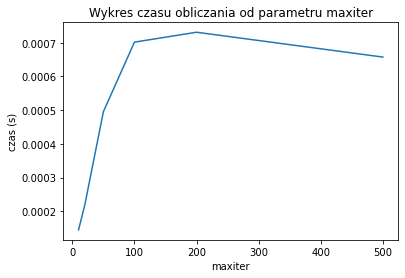

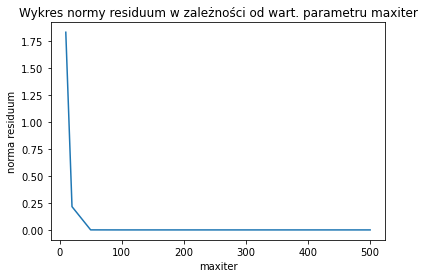

In [17]:
%load_ext memory_profiler

#JACOBI
max_iter = [10, 20, 50, 100, 200, 500]
time_list = list()
error_list = list()
for iterations_number in max_iter:
    print('Timing: ')
    saved_timing = %timeit -r 5 -n 10 -o solve_jacobi(A2,b2,x_init,maxiter=iterations_number)
    st = saved_timing.average   # średni czas próby
    time_list.append(st)
    error_list.append(np.linalg.norm(A2@solve_jacobi(A2,b2,x_init,maxiter=iterations_number)[0] - b2))
    saved_timing.stdev     # odchylenie standardowe
    print('Memory usage: ')
    %memit solve_jacobi(A2,b2,x_init)
    print('\n')

fig, ax1 = plt.subplots()
ax1.plot(max_iter,time_list)
ax1.set(title="Wykres czasu obliczania od parametru maxiter",xlabel="maxiter",ylabel="czas (s)")

fig, ax2 = plt.subplots()
ax2.plot(max_iter,error_list)
ax2.set(title="Wykres normy residuum w zależności od wart. parametru maxiter",xlabel="maxiter",ylabel="norma residuum")

WNIOSKI DLA POWYŻSZYCH WYKRESÓW:
-LICZBA POTRZEBNYCH ITERACJI ABY OTRZYMAĆ NORMĘ RESIDUUM NIŻSZĄ NIŻ EPSILON WYNOSI MNIEJ NIŻ 100 (71),
-NORMA RESIDUUM SPADA DO OKOLIC ZERA DLA MAXITER = 50

Timing: 
251 µs ± 9.79 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 145.22 MiB, increment: 0.00 MiB


Timing: 
242 µs ± 10.7 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 145.22 MiB, increment: 0.00 MiB


Timing: 
241 µs ± 10.8 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 145.22 MiB, increment: 0.00 MiB


Timing: 
237 µs ± 2.32 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 145.23 MiB, increment: 0.00 MiB


Timing: 
240 µs ± 9.66 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 145.23 MiB, increment: 0.00 MiB


Timing: 
239 µs ± 7.15 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 145.24 MiB, increment: 0.01 MiB




[Text(0, 0.5, 'norma residuum'),
 Text(0.5, 0, 'maxiter'),
 Text(0.5, 1.0, 'Wykres normy residuum w zależności od wart. parametru maxiter')]

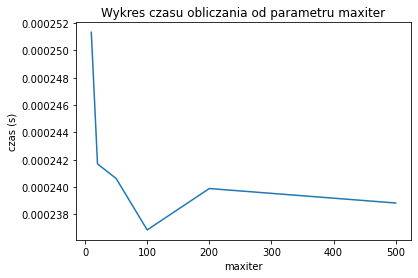

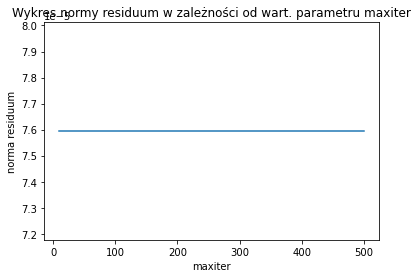

In [26]:
#GMRES
max_iter = [10, 20, 50, 100, 200, 500]
time_list = list()
error_list = list()
for iterations_number in max_iter:
    print('Timing: ')
    saved_timing = %timeit -r 5 -n 10 -o sp_linalg.gmres(A2,b2, maxiter = iterations_number)
    st = saved_timing.average   # średni czas próby
    time_list.append(st)
    error_list.append(np.linalg.norm(A2@sp_linalg.gmres(A2,b2, maxiter = iterations_number)[0] - b2))
    saved_timing.stdev     # odchylenie standardowe
    print('Memory usage: ')
    %memit sp_linalg.gmres(A2,b2, maxiter = iterations_number)
    print('\n')

fig, ax1 = plt.subplots()
ax1.plot(max_iter,time_list)
ax1.set(title="Wykres czasu obliczania od parametru maxiter",xlabel="maxiter",ylabel="czas (s)")

fig, ax2 = plt.subplots()
ax2.plot(max_iter,error_list)
ax2.set(title="Wykres normy residuum w zależności od wart. parametru maxiter",xlabel="maxiter",ylabel="norma residuum")

WNIOSKI DLA POWYŻSZYCH WYKRESÓW:
- TAK JAK DLA MACIERZY A1 NORMĘ RESIDUUM NA BARDZO DOBRYM POZIOMIE (10^-5) OTRZYMUJEMY BARDZO SZYBKO (PRZY 10 ITERACJACH)
- WYKRES CZASU ZA KAŻDYM RAZEM GENERUJE SIĘ INNY, JEDNAK JEST TO SPOWODOWANE TYM, ŻE CZAS WYKONYWANIA JEST I TAK NA BARDZO PODOBNYM POZIOMIE.

***Zadanie 7***   
Rozwiąż układ równań z Zadania 3 podpunkt c) przy pomocy:

- funkcji *[solve](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.solve.html?highlight=solve#numpy.linalg.solve)* z biblioteki numpy

- zaimplementowanej iteracyjnej metody *solve_jacobi*

- iteracyjnej metody *[gradientów sprzężonych](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.cg.html)*
 z biblioteki scipy

- iteracyjnej metody *[GMRES](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.gmres.html)*
 z biblioteki scipy

Przed każdą metodą sprawdź czy warunki dotyczące macierzy dla danej metody są spełnione. Zbadaj dokładność i czas obliczeń metod w zależności od liczby iteracji. Wyniki przedstaw na wykresach.

In [20]:
### ROZWIĄZANIA UKŁADU RÓWNAŃ Z ZADANIA 3 Z PODPUNKTU c) PRZY POMOCY:  

print("MACIERZ A3 Z ZADANIA 3 Z PODPUNKTU c)\n")
# SOLVE
print("METODA SOLVE \n")
solution_S_3 = np_linalg.solve(A3,b3)
print("Wynik dla macierzy A3 i funkcji SOLVE: ",solution_S_3,"\n\n")

# SOLVE JACOBI
print("METODA SOLVE JACOBI\n")
condition_SJ_3 = is_diag_dominant(A3)
print("Czy warunek dla funkcji solve_jacobi i macierzy A3 jest spełniony? ",condition_SJ_3,"\n")
x_init = np.zeros(m)
solution_SJ_3, n_3 = solve_jacobi(A3,b3,x_init)
print("Wynik dla macierzy A3 i funkcji solve_jacobi: ",solution_SJ_3,"\n")
print("Liczba iteracji: ",n_3,"\n")

# GRADIENTY SPRZĘŻONE
print("METODA GRADIENTÓW SPRZĘŻONYCH\n")
condition_GS_3 = is_symmetric(A3)
print("Czy warunek dla gradientów sprzężonych i macierzy A3 jest spełniony? ",condition_GS_3,"\n")
solution_GS_3, _ = sp_linalg.cg(A3,b3)
print("Wynik dla macierzy A3 i metody Gradientów sprzeżonych: ",solution_GS_3,"\n\n")

# GMRES
solution_GMRES_3, _ = sp_linalg.gmres(A3,b3)
print("Wynik dla macierzy A3 i funkcji GMRES: ",solution_GMRES_3,"\n\n")

MACIERZ A3 Z ZADANIA 3 Z PODPUNKTU c)

METODA SOLVE 

Wynik dla macierzy A3 i funkcji SOLVE:  [ 0.03013173  0.01700646  0.00881256  0.03426832 -0.021414   -0.0110388
  0.00769253 -0.00610913 -0.00038101 -0.02495023] 


METODA SOLVE JACOBI

Czy warunek dla funkcji solve_jacobi i macierzy A3 jest spełniony?  False 

Wynik dla macierzy A3 i funkcji solve_jacobi:  [-5.58050105e+81 -8.35230309e+81 -9.77274446e+81 -9.39733866e+81
 -1.12844768e+82 -5.40449002e+81 -6.67514901e+81 -7.91786018e+81
 -2.40999356e+82 -1.04888365e+82] 

Liczba iteracji:  100 

METODA GRADIENTÓW SPRZĘŻONYCH

Czy warunek dla gradientów sprzężonych i macierzy A3 jest spełniony?  True 

Wynik dla macierzy A3 i metody Gradientów sprzeżonych:  [ 0.03013173  0.01700646  0.00881256  0.03426832 -0.021414   -0.0110388
  0.00769253 -0.00610913 -0.00038101 -0.02495023] 


Wynik dla macierzy A3 i funkcji GMRES:  [ 0.03013173  0.01700646  0.00881256  0.03426832 -0.021414   -0.0110388
  0.00769253 -0.00610913 -0.00038101 -0.024950

WNIOSKI:
- OTRZYMUJEMY WŁAŚCIWE WYNIKI DLA FUNKCJI SOLVE, METODY GRADIENTÓW SPRZĘŻONYCH (DLA KTÓREJ SPEŁNIONY JEST WARUNEK SYMETRYCZNOŚCI) ORAZ GMRES,
- DLA METODY SOLVE JACOBI, DLA KTÓREJ NIE JEST SPEŁIONY WARUNEK UZYSKUJEMY OGROMNE WARTOŚCI (e119), FUNKCJA TA NIE DZIAŁA POPRAWNIE 

Timing: 
341 µs ± 41.2 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 144.60 MiB, increment: 0.00 MiB


Timing: 
285 µs ± 9.27 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 144.60 MiB, increment: 0.00 MiB


Timing: 
334 µs ± 13.8 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 144.60 MiB, increment: 0.00 MiB


Timing: 
344 µs ± 12.1 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 144.60 MiB, increment: 0.00 MiB


Timing: 
335 µs ± 14.5 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 144.60 MiB, increment: 0.00 MiB


Timing: 
333 µs ± 6.87 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 144.60 MiB, increment: 0.00 MiB




[Text(0, 0.5, 'norma residuum'),
 Text(0.5, 0, 'maxiter'),
 Text(0.5, 1.0, 'Wykres normy residuum w zależności od wart. parametru maxiter')]

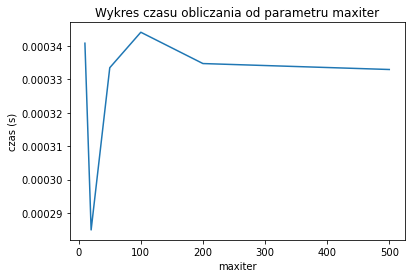

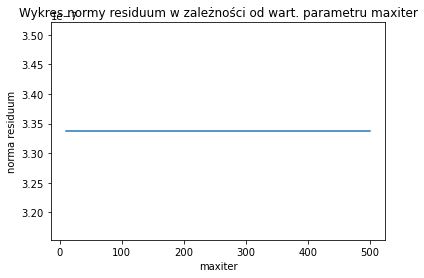

In [24]:
#GRADIENTY SPRZĘŻONE
max_iter = [10, 20, 50, 100, 200, 500]
time_list = list()
error_list = list()
for iterations_number in max_iter:
    print('Timing: ')
    saved_timing = %timeit -r 5 -n 10 -o sp_linalg.cg(A3,b3,maxiter=iterations_number)
    st = saved_timing.average   # średni czas próby
    time_list.append(st)
    error_list.append(np.linalg.norm(A3@sp_linalg.cg(A3,b3)[0] - b3))
    saved_timing.stdev     # odchylenie standardowe
    print('Memory usage: ')
    %memit sp_linalg.cg(A3,b3)
    print('\n')

fig, ax1 = plt.subplots()
ax1.plot(max_iter,time_list)
ax1.set(title="Wykres czasu obliczania od parametru maxiter",xlabel="maxiter",ylabel="czas (s)")

fig, ax2 = plt.subplots()
ax2.plot(max_iter,error_list)
ax2.set(title="Wykres normy residuum w zależności od wart. parametru maxiter",xlabel="maxiter",ylabel="norma residuum")

WNIOSKI DLA POWYŻSZYCH WYKRESÓW:
- NORMA RESIDUUM NA POZIOMIE ZERA MASZYNOWEGO JUŻ PRZY 10 ITERACJACH,
- CZAS WYKONYWANIA PODOBNY DLA WSZYSTKICH WARTOŚCI MAXITER GDYŻ FUNKCJA WYKONUJE SIĘ I TAK TYLE RAZY CO DLA 10 ITERACJI.

Timing: 
319 µs ± 18.7 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 147.29 MiB, increment: 0.00 MiB


Timing: 
296 µs ± 10.1 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 147.29 MiB, increment: 0.00 MiB


Timing: 
295 µs ± 11.5 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 147.29 MiB, increment: 0.00 MiB


Timing: 
293 µs ± 9.12 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 147.29 MiB, increment: 0.00 MiB


Timing: 
294 µs ± 10.5 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 147.29 MiB, increment: 0.00 MiB


Timing: 
276 µs ± 40 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)
Memory usage: 
peak memory: 147.29 MiB, increment: 0.00 MiB




[Text(0, 0.5, 'norma residuum'),
 Text(0.5, 0, 'maxiter'),
 Text(0.5, 1.0, 'Wykres normy residuum w zależności od wart. parametru maxiter')]

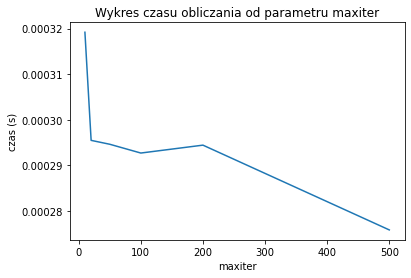

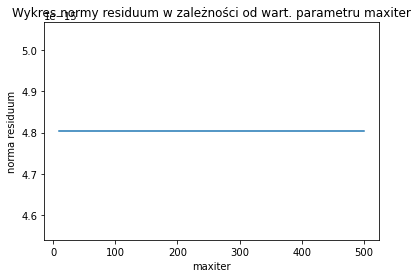

In [28]:
#GMRES
max_iter = [10, 20, 50, 100, 200, 500]
time_list = list()
error_list = list()
for iterations_number in max_iter:
    print('Timing: ')
    saved_timing = %timeit -r 5 -n 10 -o sp_linalg.gmres(A3,b3, maxiter = iterations_number)
    st = saved_timing.average   # średni czas próby
    time_list.append(st)
    error_list.append(np.linalg.norm(A3@sp_linalg.gmres(A3,b3, maxiter = iterations_number)[0] - b3))
    saved_timing.stdev     # odchylenie standardowe
    print('Memory usage: ')
    %memit sp_linalg.gmres(A3,b3, maxiter = iterations_number)
    print('\n')

fig, ax1 = plt.subplots()
ax1.plot(max_iter,time_list)
ax1.set(title="Wykres czasu obliczania od parametru maxiter",xlabel="maxiter",ylabel="czas (s)")

fig, ax2 = plt.subplots()
ax2.plot(max_iter,error_list)
ax2.set(title="Wykres normy residuum w zależności od wart. parametru maxiter",xlabel="maxiter",ylabel="norma residuum")

WNIOSKI DLA POWYŻSZYCH WYKRESÓW:
- NORMA RESIDUUM NA POZIOMIE ZERA MASZYNOWEGO JUŻ PRZY 10 ITERACJACH,
- CZAS WYKONYWANIA PODOBNY DLA WSZYSTKICH WARTOŚCI MAXITER GDYŻ FUNKCJA WYKONUJE SIĘ I TAK TYLE RAZY CO DLA 10 ITERACJI.

WNIOSKI KOŃCOWE:

- MACIERZ A1 (RANDOMOWYCH LICZB CAŁKOWITYCH):
    1. Dobrze spisuje się jedynie funkcja solve oraz funkcja GMRES (są one uniwersalne dla wszystkich typowych macierzy jeśli działają dla macierzy liczb losowych),
    2. Metoda solve_jacobi oraz gradientów sprzężonych nie radzi sobie z taką macierzą, ponieważ nie są spełnione odpowiednie warunki,
    3. Dla tej macierzy najmniej metod obliczeń się sprawdza, jest więc ona najtrudniejszym przypadkiem.

- MACIERZ A2 (DIAGONALNIE ZDOMINOWANA):
    1. Funkcja solve oraz GMRES ponownie działa bardzo dobrze,
    2. Metoda solve_jacobi potrzebuje 71 iteracji aby otrzymać dobry wynik, jest to sporo, jednak działa ona poprawnie.
    3. Funkcja GMRES działa poprawnie i dość szybko otrzymujemy poprawność (10^-5).
    4. Metoda Gradientów Sprzężonych, dla której nie jest spełniony warunek symetryczności macierzy dokonuje błędów, jednak nie są one tak duże jak w przypadku macierzy A1, wyniki dają               orientacyjny pogląd co do prawdziwych wartości.
    
- MACIERZ A3 (SYMETRYCZNA):

    1. Funkcje solve oraz GMRES znowu działają poprawnie.
    2. Dla GMRES residuum na poziomie zera maszynowego.
    3. Dla Gradientów Sprzężonych funkcja działa poprawnie gdyż spełniony jest warunek o symetryczności macierzy. Norma residuum na poziomie (10^-7).
    4. Funkcja solve jacobi nie działa poprawnie, zwraca liczby na poziomie e119.

Materiały uzupełniające:
- [Scipy Lecture Notes](http://www.scipy-lectures.org/index.html)
- [NumPy for Matlab users](https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html#numpy-for-matlab-users)
- [Python Tutorial - W3Schools](https://www.w3schools.com/python/default.asp)
- [NumPy](https://www.numpy.org)
- [Matplotlib](https://matplotlib.org/)
- [Anaconda](https://www.anaconda.com/)
- [Learn Python for Data Science](https://www.datacamp.com/learn-python-with-anaconda?utm_source=Anaconda_download&utm_campaign=datacamp_training&utm_medium=banner)
- [Learn Python](https://www.learnpython.org/)
- [Wujek Google](https://google.pl) i [Ciocia Wikipedia](https://pl.wikipedia.org/wiki/Wikipedia:Strona_g%C5%82%C3%B3wna)